## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [18]:
# first let's generate data, you can ignore this part
import numpy as np

# generate 10000 points from multivariate gaussian with 30 dimensions
cov = np.cov(np.random.randn(30, 10))
mean = np.zeros(30)
X = np.random.multivariate_normal(mean, cov, 10000)

# split into train and test
X_train = X[:8000, :25]
X_val = X[8000:9000, :25]
X_test = X[9000:, :25]
y_train = X[:8000, 25:] + np.random.randn(8000, 5)
y_val = X[8000:9000, 25:] + np.random.randn(1000, 5)
y_test = X[9000:, 25:] + np.random.randn(1000, 5)

# set up torch dataset
import torch
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [19]:
import torch
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(25, 5)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [28]:
# train model
best_loss = 1e10
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))
    

Epoch [1/100], Loss: 1.0152
Epoch [1/100], Val Loss: 1.0373
Epoch [2/100], Loss: 0.8187
Epoch [2/100], Val Loss: 1.0365
Epoch [3/100], Loss: 0.9831
Epoch [3/100], Val Loss: 1.0369
Epoch [4/100], Loss: 0.8201
Epoch [4/100], Val Loss: 1.0387
Epoch [5/100], Loss: 0.9857
Epoch [5/100], Val Loss: 1.0368
Epoch [6/100], Loss: 0.9418
Epoch [6/100], Val Loss: 1.0378
Epoch [7/100], Loss: 0.9868
Epoch [7/100], Val Loss: 1.0349
Epoch [8/100], Loss: 1.0572
Epoch [8/100], Val Loss: 1.0290
Epoch [9/100], Loss: 1.1955
Epoch [9/100], Val Loss: 1.0306
Epoch [10/100], Loss: 1.0166
Epoch [10/100], Val Loss: 1.0437
Epoch [11/100], Loss: 0.8527
Epoch [11/100], Val Loss: 1.0354
Epoch [12/100], Loss: 0.7972
Epoch [12/100], Val Loss: 1.0368
Epoch [13/100], Loss: 0.9702
Epoch [13/100], Val Loss: 1.0301
Epoch [14/100], Loss: 0.9254
Epoch [14/100], Val Loss: 1.0315
Epoch [15/100], Loss: 1.0208
Epoch [15/100], Val Loss: 1.0317
Epoch [16/100], Loss: 1.0876
Epoch [16/100], Val Loss: 1.0396
Epoch [17/100], Loss: 1.12

<All keys matched successfully>

In [29]:
# evaluate model on test set
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.8868


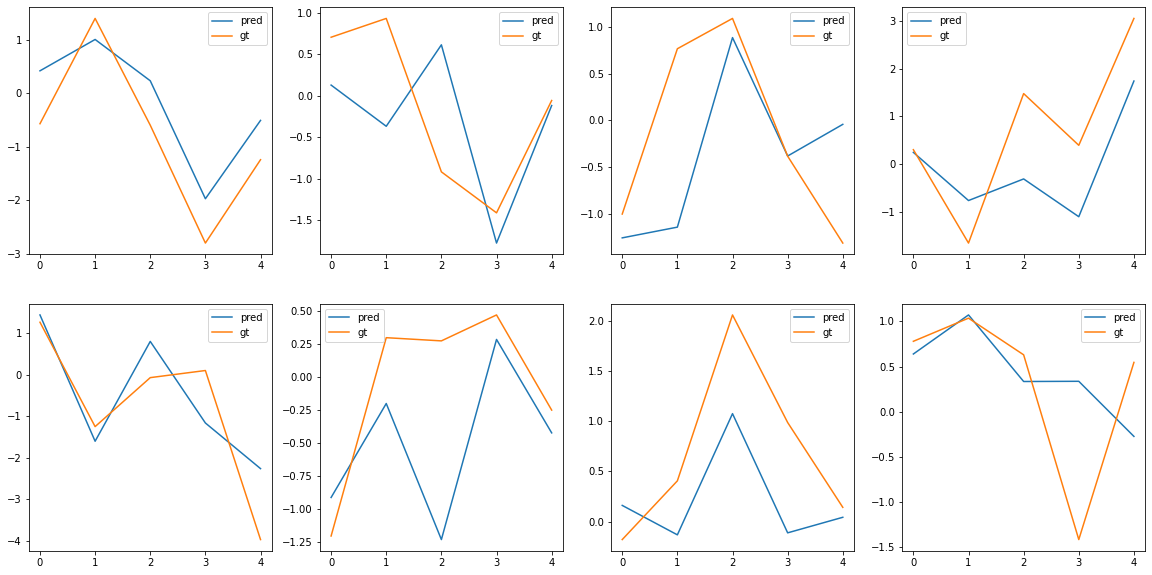

In [30]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [26]:
# define model
import torch
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(25, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 5)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(x)))
        return y_pred

In [31]:
# train model
best_loss = 1e10
model = MLP(100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/100], Loss: 1.1803
Epoch [1/100], Val Loss: 1.1293
Epoch [2/100], Loss: 1.1910
Epoch [2/100], Val Loss: 1.0280
Epoch [3/100], Loss: 1.0142
Epoch [3/100], Val Loss: 1.0201
Epoch [4/100], Loss: 1.0791
Epoch [4/100], Val Loss: 1.0122
Epoch [5/100], Loss: 0.9166
Epoch [5/100], Val Loss: 1.0076
Epoch [6/100], Loss: 0.9518
Epoch [6/100], Val Loss: 1.0094
Epoch [7/100], Loss: 1.0698
Epoch [7/100], Val Loss: 1.0103
Epoch [8/100], Loss: 0.8136
Epoch [8/100], Val Loss: 1.0077
Epoch [9/100], Loss: 1.0784
Epoch [9/100], Val Loss: 1.0014
Epoch [10/100], Loss: 0.9948
Epoch [10/100], Val Loss: 1.0128
Epoch [11/100], Loss: 0.9887
Epoch [11/100], Val Loss: 1.0157
Epoch [12/100], Loss: 0.8690
Epoch [12/100], Val Loss: 1.0105
Epoch [13/100], Loss: 0.9888
Epoch [13/100], Val Loss: 1.0238
Epoch [14/100], Loss: 1.0207
Epoch [14/100], Val Loss: 1.0168
Epoch [15/100], Loss: 1.0180
Epoch [15/100], Val Loss: 1.0067
Epoch [16/100], Loss: 1.0692
Epoch [16/100], Val Loss: 1.0141
Epoch [17/100], Loss: 1.05

<All keys matched successfully>

In [32]:
# evaluate model on test set
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 0.8975


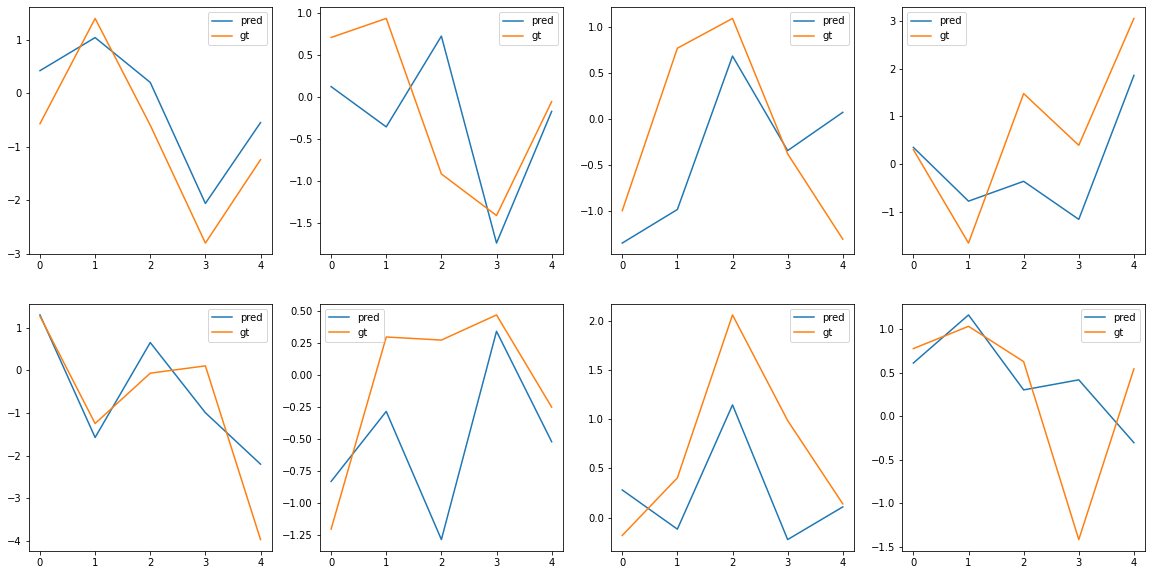

In [33]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()